In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 11.0 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting object

---

In [ ]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [ ]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [ ]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.0001,
    "n_epochs": 50,
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 400,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
}

In [ ]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [ ]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat_orig.pkl'
video_data = read_I3D_pkl(I3D_data_path, feat_size="400")
video_classes, attr_mat = video_data['activity'], video_data['features']

In [ ]:
# re-arrange semantic space
activity_dict = dict(zip(video_classes, attr_mat))
semantic_space = np.array([activity_dict[c] for c in actionList])

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        y_feat = self.attributes[target, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = self.attributes[self.action_classes, ...]
        return cls_feat

In [ ]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
def newLoss(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4, figsize=(15, 15))
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [ ]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [ ]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-21-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-70


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.578



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.724



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.837



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.799



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.889



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.902



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.892



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.919



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.895



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.924



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.863



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.853



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.954



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.957



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.925



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.948



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.959



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.950



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.930



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

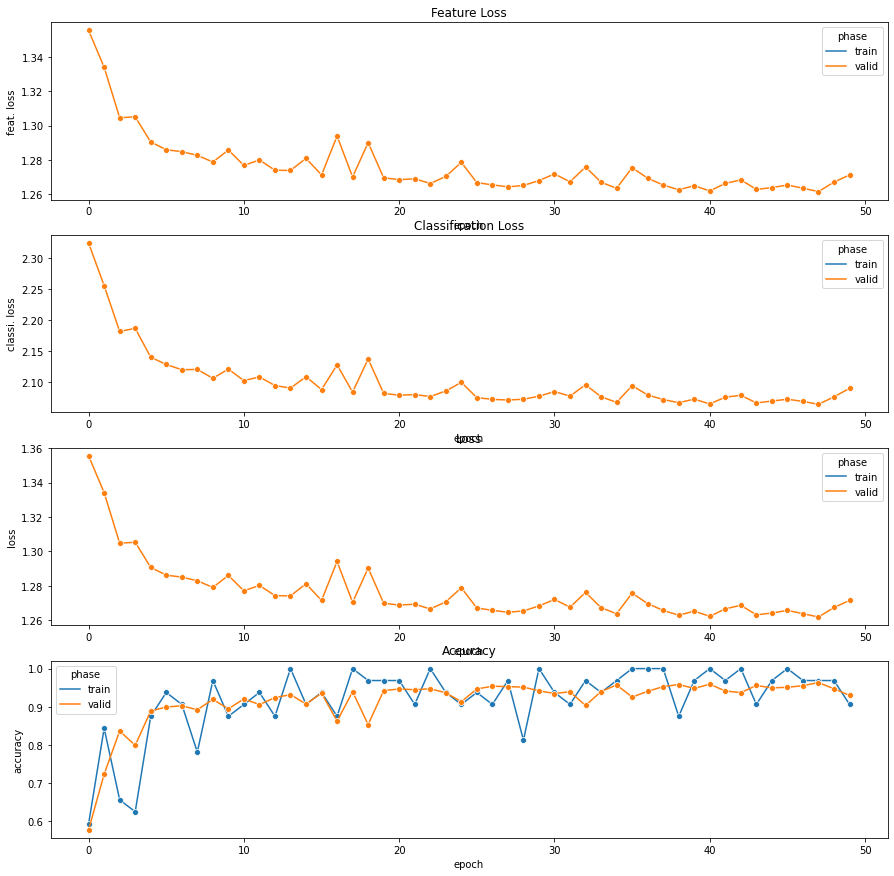

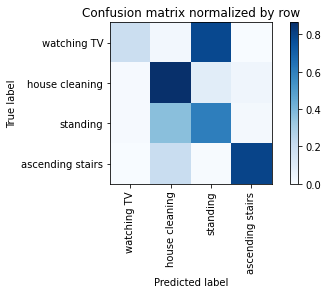

Overall accuracy: 0.665

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.575      0.604      0.589      0.330       1849|	 house cleaning: 0.367,	ascending stairs: 0.020,	
  house cleaning       0.635      0.865      0.732      0.329       1840|	 standing: 0.092,	ascending stairs: 0.036,	
ascending stairs       0.892      0.794      0.840      0.193       1080|	 house cleaning: 0.202,	standing: 0.004,	
     watching TV       0.843      0.194      0.315      0.148        831|	 standing: 0.783,	house cleaning: 0.023,	

----------------------------------------------------------------------------------------------------
     avg / total       0.696      0.665      0.644        1.0       5600|	      

{'accuracy': 0.6653571428571429, 'precision': 0.7361761541170462, 'recall': 0.6141075833635942, 'f1': 0.6191234506686851, 'samples': 5600, 'loss': 7742.053123474121, 'feat. loss': 7741.3956871032715, 'classi. loss': 6574.6882

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.668



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.755



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.798



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.866



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.859



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.878



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.898



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.909



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.917



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.908



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.931



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.926



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.905



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.927



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.926



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.934



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

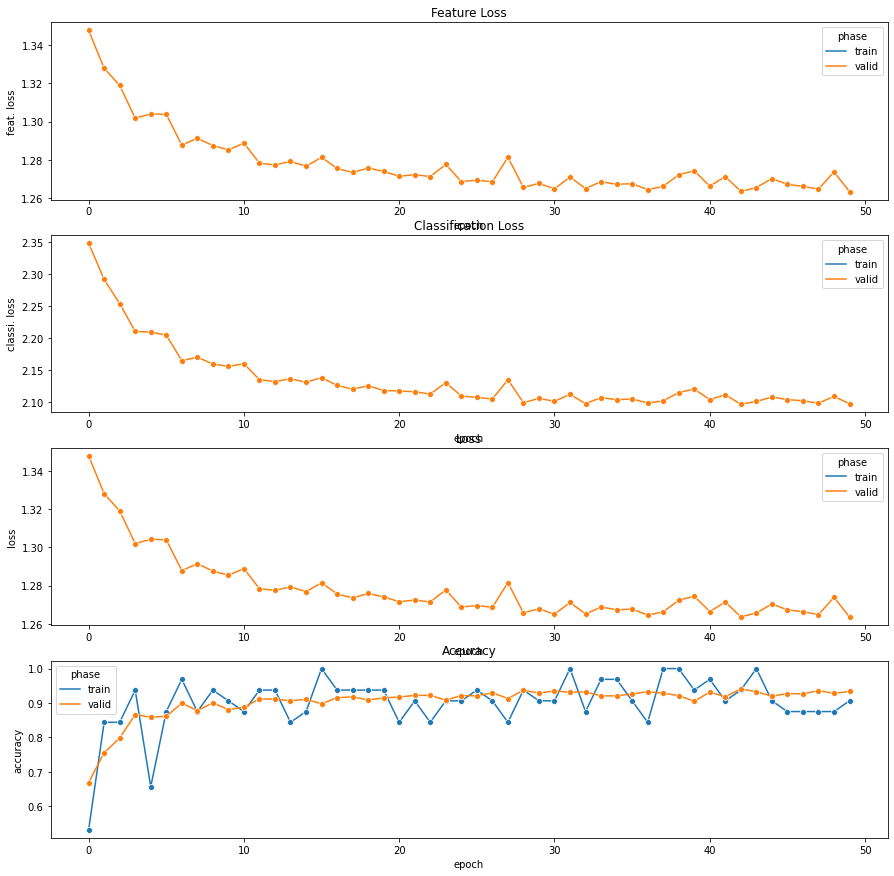

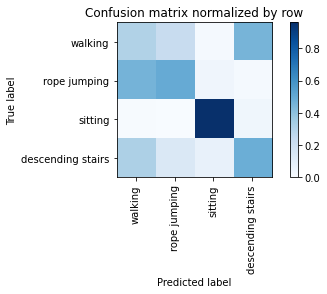

Overall accuracy: 0.562

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.576      0.302      0.396      0.421       2328|	 descending stairs: 0.454,	rope jumping: 0.232,	
          sitting       0.937      0.961      0.949      0.324       1795|	 descending stairs: 0.035,	walking: 0.004,	
descending stairs       0.288      0.478      0.359      0.172        952|	 walking: 0.314,	rope jumping: 0.136,	
     rope jumping       0.253      0.492      0.335      0.083        461|	 walking: 0.456,	sitting: 0.039,	

----------------------------------------------------------------------------------------------------
      avg / total       0.617      0.562      0.564        1.0       5536|	      

{'accuracy': 0.5615968208092486, 'precision': 0.513548883525921, 'recall': 0.5582245407122788, 'f1': 0.5096583902877032, 'samples': 5536, 'loss': 7558.235260009766, 'feat. loss': 7557.60774230957, 'classi. loss': 6275.228244781494}

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.368



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.725



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.817



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.806



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.828



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.836



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.863



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.879



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.893



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.871



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.890



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.936



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.924



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.843



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.885



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.931



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.896



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.949



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.940



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.938



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

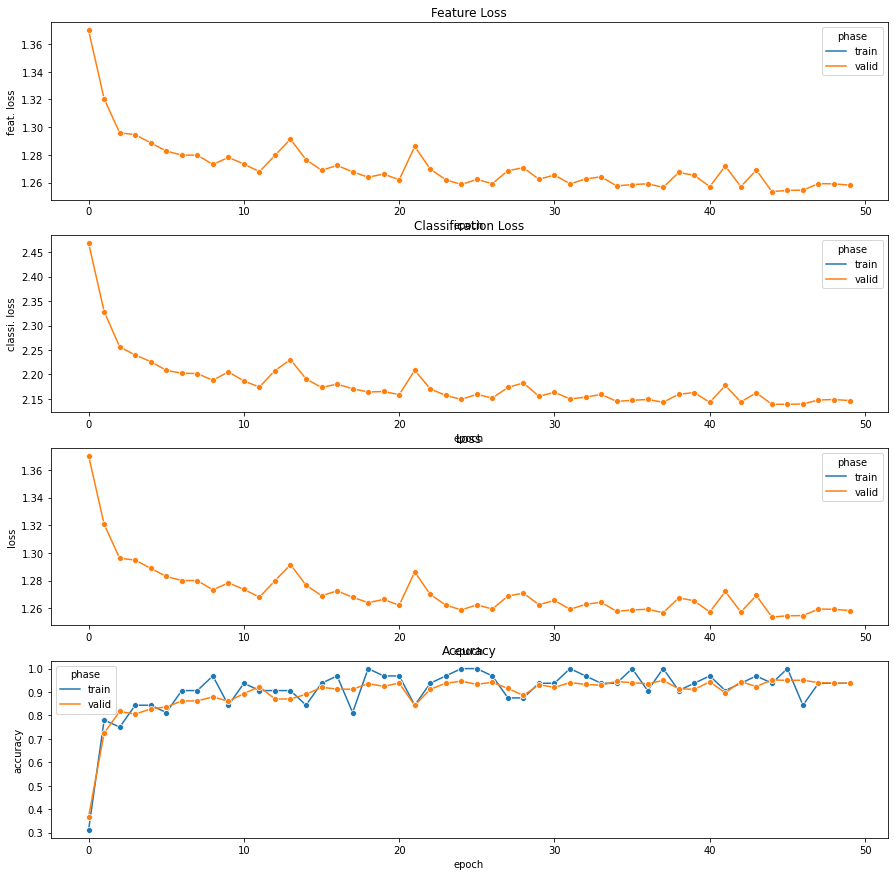

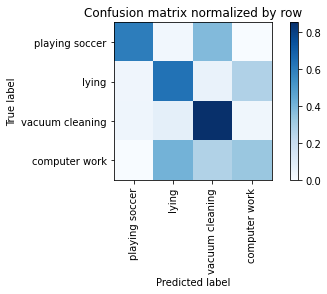

Overall accuracy: 0.551

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.643      0.327      0.433      0.432       3071|	 lying: 0.406,	vacuum cleaning: 0.267,	
          lying       0.461      0.636      0.534      0.264       1874|	 computer work: 0.270,	vacuum cleaning: 0.060,	
vacuum cleaning       0.568      0.852      0.681      0.240       1702|	 lying: 0.079,	playing soccer: 0.038,	
 playing soccer       0.677      0.597      0.635      0.064        457|	 vacuum cleaning: 0.376,	lying: 0.026,	

----------------------------------------------------------------------------------------------------
    avg / total       0.579      0.551      0.532        1.0       7104|	      

{'accuracy': 0.5513795045045045, 'precision': 0.5870624795171256, 'recall': 0.6028639352757418, 'f1': 0.5708574204596127, 'samples': 7104, 'loss': 10277.120105743408, 'feat. loss': 10276.247512817383, 'classi. loss': 8726.070426940918}
======

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.538



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.660



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.793



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.708



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.799



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.777



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.869



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.845



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.855



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.850



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.865



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.875



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.909



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.896



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.909



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.905



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.912



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.905



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.904



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.757



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.916



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.858



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.934



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.900



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.910



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.919



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.926



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.931



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.937



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

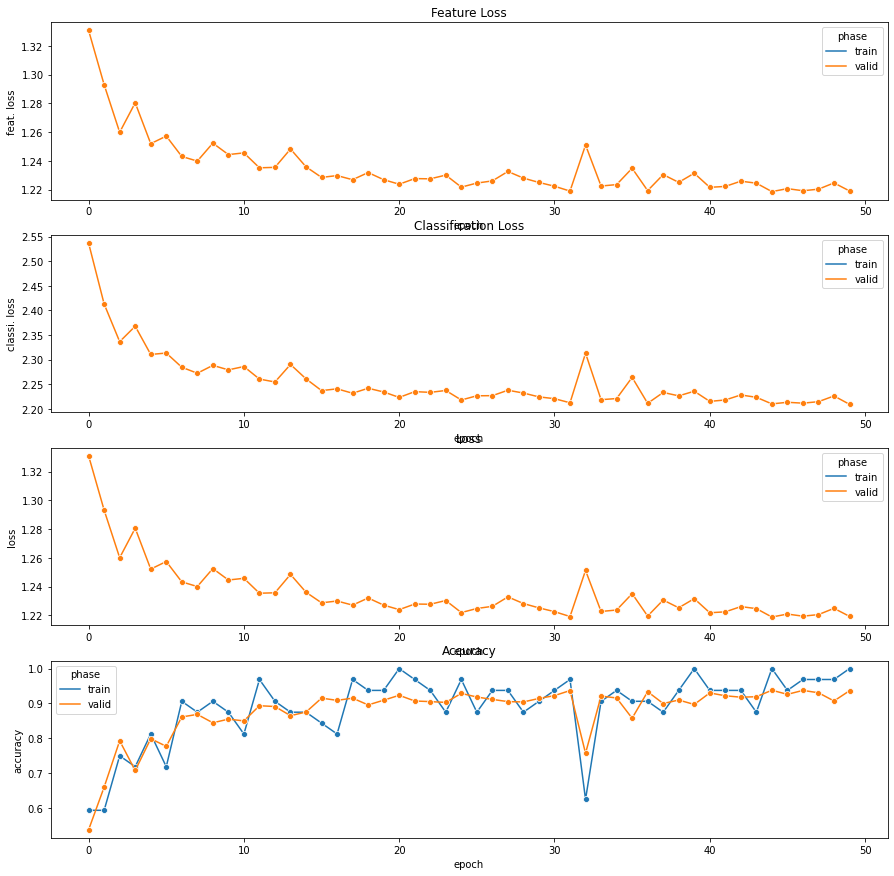

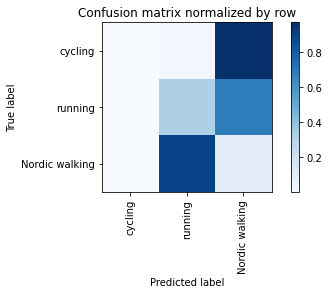

Overall accuracy: 0.112

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.078      0.101      0.088      0.418       1833|	 running: 0.899,	cycling: 0.001,	
       cycling       0.500      0.002      0.004      0.366       1605|	 Nordic walking: 0.969,	running: 0.029,	
       running       0.151      0.318      0.205      0.216        946|	 Nordic walking: 0.680,	cycling: 0.002,	

----------------------------------------------------------------------------------------------------
   avg / total       0.248      0.112      0.082        1.0       4384|	      

{'accuracy': 0.11154197080291971, 'precision': 0.24285117657222224, 'recall': 0.1403261394710987, 'f1': 0.0987421330482073, 'samples': 4384, 'loss': 7311.129093170166, 'feat. loss': 7310.625736236572, 'classi. loss': 5033.408599853516}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4,

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.571



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.732



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.827



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.814



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.853



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.873



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.925



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.913



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.943



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.947



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.869



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.954



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.956



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.960



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.802



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.954



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.958



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.955



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.951



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.954



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.911



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.952



train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.918



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

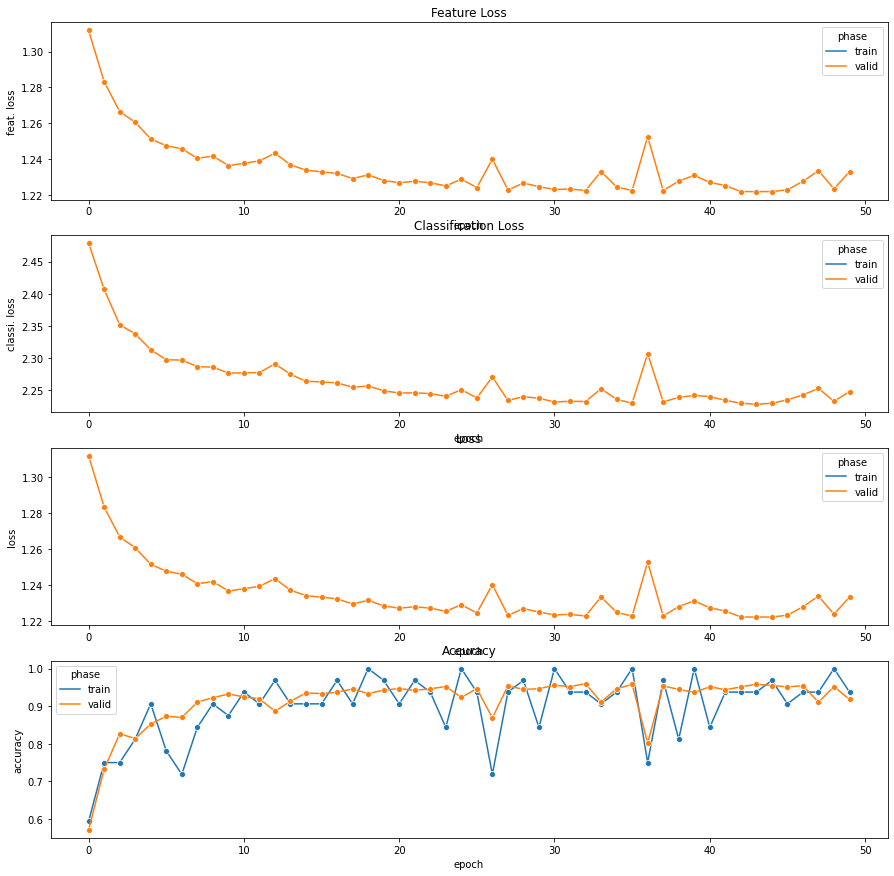

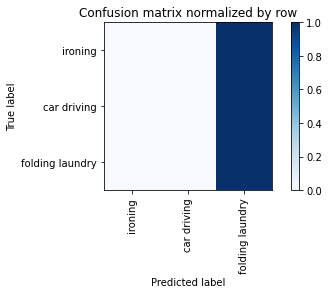

Overall accuracy: 0.253

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       2332|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.253      1.000      0.404      0.253        971|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        537|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.064      0.253      0.102        1.0       3840|	      

{'accuracy': 0.25286458333333334, 'precision': 0.08428819444444445, 'recall': 0.3333333333333333, 'f1': 0.1345527610337421, 'samples': 3840, 'loss': 6503.732929229736, 'feat. loss': 6503.281799316406, 'classi. loss': 4511.309429168701}
============== Overall Unseen Classes Performance ==============
accuracy           0.428548
precision          0.432785

In [ ]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=semantic_space, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=semantic_space, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'valid', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()
